In [ ]:
%pip install vaderSentiment
%pip install gensim
%pip install pyLDAvis
%pip install transformers torch

In [3]:
import datetime
import time
import requests
import json
import re
import numpy as np
import pandas as pd
import seaborn as sns

# Reddit API
import praw

# Natural Language Processing (NLP)
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Topic Modeling
from gensim import corpora
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser

# Visualization
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Transformers
from transformers import pipeline

# Miscellaneous
from pprint import pprint
from IPython import display


c:\Desktop\coding\MYDAC-Curriculum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Initialize Reddit API
reddit = praw.Reddit(
    client_id=open('cred/client_id.txt').read().strip(),
    client_secret=open('cred/client_secret.txt').read().strip(),
    user_agent=open('cred/user_agent.txt').read().strip(),
)

# Define Reddit post URL
reddit_post_url = "https://www.reddit.com/r/electricvehicles/comments/1e7x13p/it_is_not_the_evs_that_are_lacking_in_the_us_its/"
submission = reddit.submission(url=reddit_post_url)

# Create a list to hold comment data
comments_data = []

# Fetch and store comments
submission.comments.replace_more(limit=None)
for comment in submission.comments.list():
    comments_data.append({
        'comment_id': comment.id,
        'author': comment.author.name if comment.author else "Deleted",
        'score': comment.score,
        'comment_text': comment.body
    })

# Create a DataFrame
comments_df = pd.DataFrame(comments_data)

# Optional: Rename columns for clarity
comments_df.rename(columns={
    'comment_id': 'Comment ID',
    'author': 'Author',
    'score': 'Score',
    'comment_text': 'Comment Text'
}, inplace=True)

# Display DataFrame
print(comments_df.head())


  Comment ID              Author  Score  \
0    le387km             Deleted    115   
1    le39p6l          Dirks_Knee     63   
2    le3j257  iwantthisnowdammit     33   
3    le4yq2n          iSeerStone      9   
4    le3icon           StLandrew      8   

                                        Comment Text  
0  We need a lot more L2 AC to reduce the need of...  
1  You're kinda the inverse example which highlig...  
2  We’re in the “before USB outlets on airplanes”...  
3  Chargers should be:\n1. Maintained like gas pu...  
4  I have to record this for posterity. "I own a ...  


c:\Desktop\coding\MYDAC-Curriculum\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ysuns\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)



Sentiment Analysis Results:
                                        Comment Text Sentiment Label  \
0  We need a lot more L2 AC to reduce the need of...         neutral   
1  You're kinda the inverse example which highlig...         neutral   
2  We’re in the “before USB outlets on airplanes”...         neutral   
3  Chargers should be:\n1. Maintained like gas pu...   contradiction   
4  I have to record this for posterity. "I own a ...         neutral   

   Sentiment Score  
0         0.984023  
1         0.977609  
2         0.665580  
3         0.580069  
4         0.986584  

Sentiment Summary:
Sentiment Label
neutral          233
contradiction     26
entailment         8
Name: count, dtype: int64

EV-Specific Sentiment Summary:
Sentiment Label
neutral          100
contradiction     10
entailment         2
Name: count, dtype: int64

Top Phrases Discussed in EV Context:
road trips                 24
charge home                13
charging stations          13
road trip             

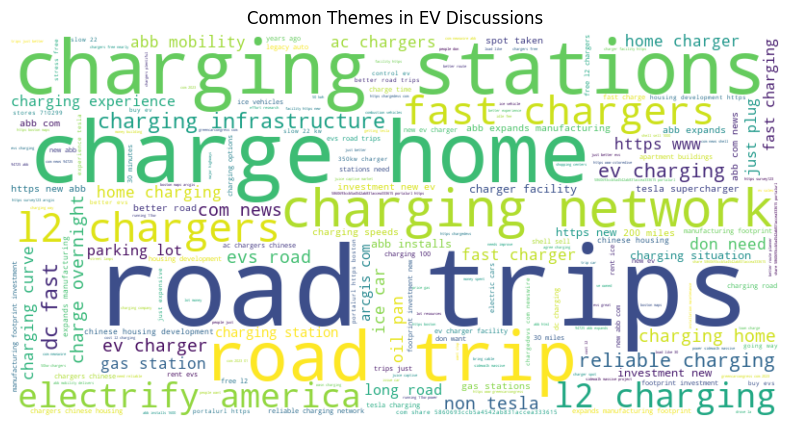

In [14]:
from transformers import pipeline
import pandas as pd

# Initialize Hugging Face sentiment-analysis pipeline with a more robust model
sentiment_pipeline = pipeline("sentiment-analysis", model="facebook/bart-large-mnli")

# Function to split long comments into chunks of 512 tokens
def split_text(text, max_length=512):
    # Split text into sentences or chunks based on punctuation (simple approach)
    sentences = text.split('.')
    chunks = []
    chunk = ''
    
    for sentence in sentences:
        if len(chunk.split()) + len(sentence.split()) <= max_length:
            chunk += sentence + '.'
        else:
            chunks.append(chunk.strip())
            chunk = sentence + '.'
    if chunk:
        chunks.append(chunk.strip())
    
    return chunks

# Define a function for contextual sentiment analysis
def contextual_sentiment_analysis(text):
    try:
        # Split text if it's too long
        chunks = split_text(text)
        
        # Aggregate sentiment results from all chunks
        sentiments = []
        for chunk in chunks:
            result = sentiment_pipeline(chunk)[0]  # Analyze sentiment
            sentiments.append((result['label'], result['score']))
        
        # Calculate overall sentiment by averaging the scores
        if sentiments:
            avg_score = sum([score for _, score in sentiments]) / len(sentiments)
            return sentiments[0][0], avg_score  # Use the first sentiment label, average score
        else:
            return "NEUTRAL", 0.0  # Return neutral if no chunks

    except Exception as e:
        return "Error", 0.0  # Handle edge cases where analysis fails

# Apply contextual sentiment analysis to the DataFrame
comments_df['Sentiment Label'], comments_df['Sentiment Score'] = zip(
    *comments_df['Comment Text'].apply(contextual_sentiment_analysis)
)

# Display results
print("\nSentiment Analysis Results:")
print(comments_df[['Comment Text', 'Sentiment Label', 'Sentiment Score']].head())

# Sentiment Summary
sentiment_summary = comments_df['Sentiment Label'].value_counts()
print("\nSentiment Summary:")
print(sentiment_summary)

# Optional: Save the enriched DataFrame to a CSV for further analysis
comments_df.to_csv("reddit_comments_with_sentiments.csv", index=False)

# **Step 2**: Identify EV-specific pain points
# Focused analysis for EV charging themes
ev_keywords = ['charging', 'station', 'range', 'battery', 'malfunction', 'slow', 'fast', 'EV', 'electric']

def extract_ev_context(comment):
    """Identify if the comment discusses EV-specific topics."""
    words = comment.lower().split()
    relevant_words = [word for word in words if word in ev_keywords]
    return " ".join(relevant_words)

# Add a column for EV-related context
comments_df['EV Context'] = comments_df['Comment Text'].apply(extract_ev_context)

# Filter comments with EV-related content for deeper analysis
ev_comments = comments_df[comments_df['EV Context'] != ""]

# Display EV-specific sentiment summary
print("\nEV-Specific Sentiment Summary:")
ev_sentiment_summary = ev_comments['Sentiment Label'].value_counts()
print(ev_sentiment_summary)

# Save EV-specific sentiments to a CSV for further exploration
ev_comments.to_csv("ev_specific_sentiments.csv", index=False)

# **Step 3**: Analyze key themes in context
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract common phrases and themes from EV-related comments
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
ngrams = vectorizer.fit_transform(ev_comments['Comment Text'])
ngram_counts = pd.DataFrame(
    ngrams.toarray(), columns=vectorizer.get_feature_names_out()
).sum().sort_values(ascending=False)

# Display top n-grams
print("\nTop Phrases Discussed in EV Context:")
print(ngram_counts.head(20))

# Generate a WordCloud for visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ngram_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Themes in EV Discussions")
plt.show()


c:\Desktop\coding\MYDAC-Curriculum\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ysuns\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Token indices sequence length is longer than the specified maximum sequence lengt


Sentiment Analysis Results:
                                        Comment Text Sentiment Label  \
0  We need a lot more L2 AC to reduce the need of...        positive   
1  You're kinda the inverse example which highlig...        positive   
2  We’re in the “before USB outlets on airplanes”...        positive   
3  Chargers should be:\n1. Maintained like gas pu...        positive   
4  I have to record this for posterity. "I own a ...        positive   

   Sentiment Score  
0         0.997967  
1         0.992574  
2         0.981097  
3         0.994396  
4         0.996952  

Sentiment Summary:
Sentiment Label
positive    261
neutral       4
Error         2
Name: count, dtype: int64

EV-Specific Sentiment Summary:
Sentiment Label
positive    110
Error         2
Name: count, dtype: int64

Top Phrases Discussed in EV Context:
road trips                 24
charge home                13
charging stations          13
road trip                  11
charging network            9
l2 charg

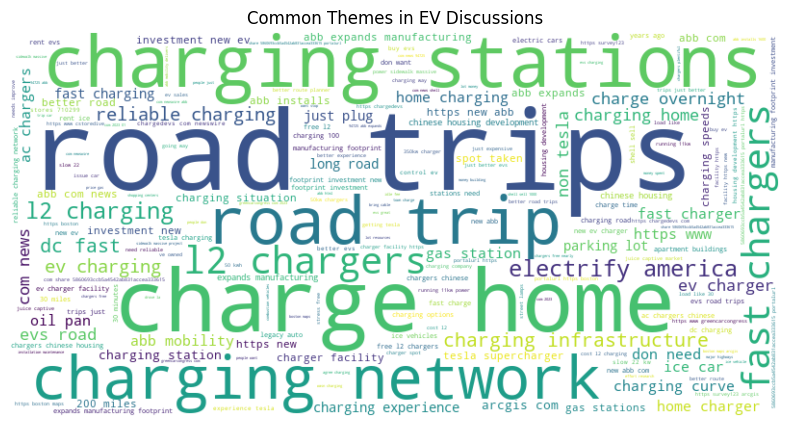

In [15]:
from transformers import pipeline
import pandas as pd

# Initialize Hugging Face sentiment-analysis pipeline with a model fine-tuned for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to split long comments into chunks of 512 tokens
def split_text(text, max_length=512):
    # Split text into sentences or chunks based on punctuation (simple approach)
    sentences = text.split('.')
    chunks = []
    chunk = ''
    
    for sentence in sentences:
        if len(chunk.split()) + len(sentence.split()) <= max_length:
            chunk += sentence + '.'
        else:
            chunks.append(chunk.strip())
            chunk = sentence + '.'
    if chunk:
        chunks.append(chunk.strip())
    
    return chunks

# Define a function for contextual sentiment analysis
def contextual_sentiment_analysis(text):
    try:
        # Split text if it's too long
        chunks = split_text(text)
        
        # Aggregate sentiment results from all chunks
        sentiments = []
        for chunk in chunks:
            result = sentiment_pipeline(chunk)[0]  # Analyze sentiment
            sentiments.append((result['label'], result['score']))
        
        # Calculate overall sentiment by averaging the scores
        if sentiments:
            avg_score = sum([score for _, score in sentiments]) / len(sentiments)
            # Convert labels into a simpler sentiment system: 'positive', 'negative', 'neutral'
            label = "neutral"
            if avg_score > 0.6:
                label = "positive"
            elif avg_score < 0.4:
                label = "negative"
            return label, avg_score  # Return sentiment label and average score
        else:
            return "neutral", 0.0  # Return neutral if no chunks

    except Exception as e:
        return "Error", 0.0  # Handle edge cases where analysis fails

# Apply contextual sentiment analysis to the DataFrame
comments_df['Sentiment Label'], comments_df['Sentiment Score'] = zip(
    *comments_df['Comment Text'].apply(contextual_sentiment_analysis)
)

# Display results
print("\nSentiment Analysis Results:")
print(comments_df[['Comment Text', 'Sentiment Label', 'Sentiment Score']].head())

# Sentiment Summary
sentiment_summary = comments_df['Sentiment Label'].value_counts()
print("\nSentiment Summary:")
print(sentiment_summary)

# Optional: Save the enriched DataFrame to a CSV for further analysis
comments_df.to_csv("reddit_comments_with_sentiments.csv", index=False)

# **Step 2**: Identify EV-specific pain points
# Focused analysis for EV charging themes
ev_keywords = ['charging', 'station', 'range', 'battery', 'malfunction', 'slow', 'fast', 'EV', 'electric']

def extract_ev_context(comment):
    """Identify if the comment discusses EV-specific topics."""
    words = comment.lower().split()
    relevant_words = [word for word in words if word in ev_keywords]
    return " ".join(relevant_words)

# Add a column for EV-related context
comments_df['EV Context'] = comments_df['Comment Text'].apply(extract_ev_context)

# Filter comments with EV-related content for deeper analysis
ev_comments = comments_df[comments_df['EV Context'] != ""]

# Display EV-specific sentiment summary
print("\nEV-Specific Sentiment Summary:")
ev_sentiment_summary = ev_comments['Sentiment Label'].value_counts()
print(ev_sentiment_summary)

# Save EV-specific sentiments to a CSV for further exploration
ev_comments.to_csv("ev_specific_sentiments.csv", index=False)

# **Step 3**: Analyze key themes in context
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract common phrases and themes from EV-related comments
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
ngrams = vectorizer.fit_transform(ev_comments['Comment Text'])
ngram_counts = pd.DataFrame(
    ngrams.toarray(), columns=vectorizer.get_feature_names_out()
).sum().sort_values(ascending=False)

# Display top n-grams
print("\nTop Phrases Discussed in EV Context:")
print(ngram_counts.head(20))

# Generate a WordCloud for visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ngram_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Themes in EV Discussions")
plt.show()
